# CS270 Final Project

#### David Gaddy, Samee Ibraheem, and Daniel Filan

## Overview

For our project, we implemented a dual decomposition algorithm for machine translation
alignments. The alignment process of machine translation tries to find words in one language
that correspond to words in another. Typical alignment models are asymmetric, so aligning
language 1 to language 2 is not the same as aligning language 2 to language 1, however we
would prefer if our alignments agreed in both directions. The paper *Model-Based Aligner
Combination Using Dual Decomposition* by John DeNero and Klaus Macherey uses a dual
decomposition algorithm to encourage agreement between the two directions. This algorithm
allows us to do effecient approximate inference while encouraging agreement by using dual
variables from a Lagragian relaxation.

## Implementation
The code for our implementation is in the file `our_align_dual.py`.  In this jupyter notebook, we will demonstrate some results that we got with our implementation.

First, let us load a model we trained on an English-Japanese parallel corpus.

In [1]:
from our_align_dual import *

t_ef, q_ef = load_model('large_models_jap/ef_model.pkl')
t_fe, q_fe = load_model('large_models_jap/fe_model.pkl')

### Baseline

We have two models, one for each direction English->Japanese and Japanese->English.  Without dual decomposition, we can use each of these directions separately or take the intersection of the alignments suggested by each directional model.

In [3]:
test_files = {'en':'data/english-test.txt', 'f':'data/japanese-test.txt'}
reverse_output = True

en_sent = load_sentences(test_files['en'])
f_sent = load_sentences(test_files['f'])

dir1_alignments = []
dir2_alignments = []
intersection_alignments = []
union_alignments = []
num_intersection = 0
num_union = 0
for i in range(len(en_sent)):
    # aligns each foreign word to the english one
    align_ef = align_ibm(en_sent[i], f_sent[i], t_ef, q_ef)
    align_ef = filter_null_alignments([(ei,fi) for fi,ei in enumerate(align_ef)])
    # aligns each english word to a foreign one
    align_fe = align_ibm(f_sent[i], en_sent[i], t_fe, q_fe)
    align_fe = filter_null_alignments([(ei,fi) for ei,fi in enumerate(align_fe)])

    dir1_alignments.append(align_ef)
    dir2_alignments.append(align_fe)

    intersection = combine_intersect(align_ef, align_fe)
    union = combine_union(align_ef, align_fe)
    num_intersection += len(intersection)
    num_union += len(union)
    intersection_alignments.append(intersection)
    union_alignments.append(union)
print('intersection over union', num_intersection / num_union)

save_alignments(dir1_alignments, 'ibm-align-dir1.txt', reverse_output)
save_alignments(dir2_alignments, 'ibm-align-dir2.txt', reverse_output)
save_alignments(intersection_alignments, 'ibm-align-intersection.txt', reverse_output)
save_alignments(union_alignments, 'ibm-align-union.txt', reverse_output)
print('direction 1')
!perl measure-alignment-error.pl data/align-test.txt ibm-align-dir1.txt
print('direction 2')
!perl measure-alignment-error.pl data/align-test.txt ibm-align-dir2.txt
print('intersection')
!perl measure-alignment-error.pl data/align-test.txt ibm-align-intersection.txt


intersection over union 0.21021102791014296
direction 1
Ref=13562	Test=14241	MatchRef=5664	MatchTest=5664
Prec=39.77	Rec=41.76	AER=59.26
direction 2
Ref=13562	Test=12426	MatchRef=5080	MatchTest=5080
Prec=40.88	Rec=37.46	AER=60.91
intersection
Ref=13562	Test=4632	MatchRef=3578	MatchTest=3578
Prec=77.25	Rec=26.38	AER=60.67


The two numbers we will focus on are labeled *intersection over union* and *AER*.  Intersection over union is a metric for how much the alignments agree between the two directions.  Higher is better, and a value of 1 would indicate perfect agreement.  AER, or alignment error rate, is a measure of how much the final alignments agree with alignments annotated by people who know both languages.  Lower AER is better.  The intersected alignment baseline gets an AER of 60.67%.

### Dual Decomposition

Dual decomposition is a method of encouraging alignments from the two different model directions to agree.  It uses Lagrange multipliers to enforce the agreement.  These Lagrange multipliers end up being combined with the model in a way that allows us to run the same inference procedure we would typically use but with slightly modified model probabilities.

Let's look at how dual decomposition affects our results:

In [4]:
alignments = []
num_converged = 0
num_intersection = 0
num_union = 0
for i in range(len(en_sent)):
    intersection, union, converged = align_dual(en_sent[i], f_sent[i], t_ef, t_fe, q_ef, q_fe, 1, 250)
    intersection = filter_null_alignments(intersection)
    union = filter_null_alignments(union)

    num_intersection += len(intersection)
    num_union += len(union)
    alignments.append(intersection)
    if converged:
        num_converged += 1
print('intersection over union',num_intersection / num_union)
print('converged',float(num_converged) / len(en_sent))

save_alignments(alignments, 'dual-decomp-intersection.txt', reverse_output)
!perl measure-alignment-error.pl data/align-test.txt dual-decomp-intersection.txt


intersection over union 0.4619582837998487
converged 0.06013745704467354
Ref=13562	Test=8549	MatchRef=4532	MatchTest=4532
Prec=53.01	Rec=33.42	AER=59.01


We can see that the intersection over union increased significantly from .21 to .46, which means that we were successful in encouraging agreement between the two directions.  The AER also improved, which means increasing agreement between the two directions led to better alignments.

In other languages, we got the following results for intersection over union and AER:

| Language  | original IOU  | IOU with dual decomposition |
|-------|-------|----|
| Chinese | .24 | .27 |
| French (10000 training sentences) | .38 | .60   |

| Language  | original AER  | AER with dual decomposition |
|-------|-------|----|
| Chinese | 55.51 | 50.56 |
| French (10000 training sentences) | 36.15 | 36.49   |

IOU consistently improves, and AER also significantly improved for Chinese.

One thing to note is that the convergence rate, or percentage of time where the two directions completely agree after dual decomposition, is very low.  Dual decomposition is an iterative algorithm, and given infinite time, it should converge 100% of the time.  However, the convergence can be very slow, and we cut off the algorithm after 250 iterations.  Even without having converged, though, we can see that it has significantly increased agreement.

### Affect of number of iterations

To see how the agreement changes with the number of iterations of dual decomposition, we plot the value intersection over union.

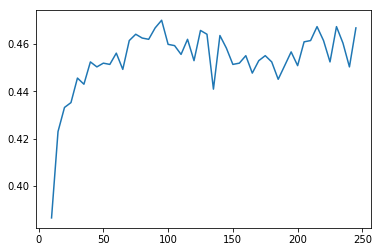

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

en_sent = en_sent[:50] # use a subset of the test set for speed
f_sent = f_sent[:50]

xs = list(range(10,250,5))
values = []
for n_iters in xs:
    num_intersection = 0
    num_union = 0
    for i in range(len(en_sent)):
        intersection, union, converged = align_dual(en_sent[i], f_sent[i], t_ef, t_fe, q_ef, q_fe, 1, n_iters)
        intersection = filter_null_alignments(intersection)
        union = filter_null_alignments(union)

        num_intersection += len(intersection)
        num_union += len(union)
        alignments.append(intersection)
        if converged:
            num_converged += 1
    values.append(num_intersection / num_union)

plt.plot(xs, values)

We can see that most of the increase in agreement happened in the first 100 iterations.  After that, the improvement in agreement flattened out.